## German-English Translator: Using Seq2seq modelling with Attention Mechanism

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import random
random.seed(42)

pd.set_option('display.max_colwidth', 200)

## Loading Data:

In [2]:
def load_data(filepath):
    ifile = open(filepath, mode='rt', encoding='utf-8')
    data = ifile.read()
    ifile.close()
    
    data = data.split('\n')
    data = [ i.split('\t') for i in data ]
    data = [ [i[0],i[1]] for i in data ]
    
    return data

In [3]:
eng_germ = load_data('./datasets/german-eng-translation.txt')
eng_germ = pd.DataFrame(eng_germ, columns=['english','german'])

eng_germ = eng_germ.iloc[:50000]

## Text Cleaning and Preprocessing:

In [8]:
import unicodedata
import re

# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(line):
    line = unicode_to_ascii(line.lower().strip())

    # creating a space between a word and the punctuation following it
    line = re.sub(r"([?.!,¿])", r" \1 ", line)
    line = re.sub(r'[" "]+', " ", line)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    line = re.sub(r"[^a-zA-Z?.!,¿]+", " ",line)

    line = line.strip()

    return line

Text(0.5, 1.0, 'Max sentence length (German): 18')

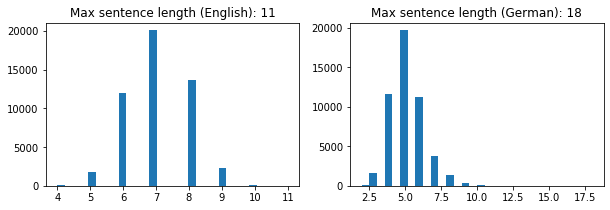

In [9]:
# Convert text to lowercase
eng_germ['english'] = eng_germ['english'].apply(lambda x: preprocess_sentence(x))
eng_germ['german'] = eng_germ['german'].apply(lambda x: preprocess_sentence(x))

# Adding '<start>' and '<end>' tokens to target variable (English)
eng_germ['english'] = eng_germ['english'].apply(lambda x: ('<BOS> ' + x + ' <EOS>'))

# Visualising sentence lengths
len_eng = eng_germ['english'].apply(lambda x: len(x.split()))
len_germ = eng_germ['german'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
_ = plt.hist(len_eng, bins = 30)
plt.title('Max sentence length (English): ' + str(max(len_eng)))
plt.subplot(1,2,2)
_ = plt.hist(len_germ, bins = 30)
plt.title('Max sentence length (German): ' + str(max(len_germ)))

## Tokenizing and Padding :

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [11]:
def tokenize(data):
    tokenizer = Tokenizer(lower = False, split=' ')
    tokenizer.fit_on_texts(data)
    
    tokenized_data = tokenizer.texts_to_sequences(data)
    word_index = tokenizer.word_index
    
    return tokenized_data, word_index

In [12]:
# Tokenization
eng_data, eng_word_index = tokenize(eng_germ['english'])
germ_data, germ_word_index = tokenize(eng_germ['german'])

eng_word_index = {i: word for word, i in eng_word_index.items()}
germ_word_index = {i: word for word, i in germ_word_index.items()}

# (+1) is for padding - '0'
eng_vocab_size = len(eng_word_index) + 1
germ_vocab_size = len(germ_word_index) + 1

print('English Vocabulary size:',eng_vocab_size)
print('German Vocabulary size:',germ_vocab_size)

English Vocabulary size: 6135
German Vocabulary size: 10105


In [13]:
# Padding
eng_max_len = max(len_eng)
germ_max_len = max(len_germ)

# We use post pading because the model needs to know where (timestamp = 1) the sentece starts
x = pad_sequences(germ_data, maxlen=germ_max_len, padding='post')
y = pad_sequences(eng_data, maxlen=eng_max_len, padding='post')

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [15]:
# Function which converts numbers back to words
def convert_int2word(data):
    
    text = []
    for line in data:
        sentence = ' '.join([eng_word_index.get(i) for i in line if eng_word_index.get(i) is not None])
        
        sentence = ' '.join([i for i in sentence.split() if i != 'BOS'])
        sentence = ' '.join([i for i in sentence.split() if i != 'EOS'])
        
        text.append(sentence)

    return text

# .................................................................................................................................
# 4. Model with Attention:

### 4.1. Training Model:

In [23]:
from tensorflow.python.keras.layers import Dense, LSTM, Embedding, Attention, AdditiveAttention, Concatenate, TimeDistributed, Dot, Activation
from tensorflow.keras import Model, Input

input_vocab_size = germ_vocab_size
output_vocab_size = eng_vocab_size
input_maxwords = germ_max_len
output_maxwords = eng_max_len - 1
hidden_units = 512

embedding_size = 300
    
# Encoder input Embedding...
encoder_input = Input(shape = (None,), name = 'encoder_input') 
encoder_embed_layer = Embedding(input_vocab_size, embedding_size, input_length=input_maxwords, mask_zero=True)
encoder_embed_input = encoder_embed_layer(encoder_input)

# Encoder part... 
encoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True, name='encoder_lstm')
encoder_output, encoder_state_h, encoder_state_c = encoder_lstm(encoder_embed_input)
encoder_state = [encoder_state_h, encoder_state_c]
    
# Decoder input Embedding - Teacher Forcing inputs instead of previous timestep's inputs...
decoder_input = Input(shape = (None,), name = 'decoder_input') 
decoder_embed_layer = Embedding(output_vocab_size, embedding_size, input_length=output_maxwords, mask_zero=True)
decoder_embed_input = decoder_embed_layer(decoder_input)

# Decoder part... 
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_output, _ , _ = decoder_lstm(decoder_embed_input, initial_state=encoder_state)
    

# Attention Layer...Luong's Attention Mechanism...
attention_value_e = Dot(axes=[2, 2], name='attention_score_e')([decoder_output, encoder_output])  # using 'Dot product' -----> (1 of 3 available methods mentioned in Luong's paper)
attention_weights = Activation('softmax', name='attention_vector')(attention_value_e)
context_vector = Dot(axes=[2,1], name='context_vector')([attention_weights, encoder_output])    
    
# attention_layer = AdditiveAttention(name='attention_layer')
# context_vector = attention_layer([decoder_output, encoder_output])

concat_layer = Concatenate(axis=-1)
decoder_combined_context = concat_layer([context_vector, decoder_output])


time_dist_layer = TimeDistributed(Dense(hidden_units, activation="tanh"))
output = time_dist_layer(decoder_combined_context)
    
dense_layer = Dense(output_vocab_size, activation='softmax', name='output_dense_layer')
decoder_pred = dense_layer(output)

# Initializing Model...
model = Model(inputs=[encoder_input, decoder_input], outputs=[decoder_pred])


In [24]:
from tensorflow.python.keras.callbacks import ModelCheckpoint

epochs = 40
batch_size=512

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])

# Assigning appropriate inputs and outputs
training_encoder_input = x_train
training_decoder_input = y_train[:,:-1]
training_decoder_output = y_train[:,1:]

filepath = './model weigths/AttentionModel_weights_40epochs.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
model.summary()

# Training the model
history = model.fit(x=[training_encoder_input, training_decoder_input], 
                    y=[training_decoder_output],
                    epochs=epochs, batch_size=batch_size, validation_split = 0.3,
                    callbacks=[checkpoint],
                    verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, None, 300)    3031500     encoder_input[0][0]              
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, None, 300)    1840500     decoder_input[0][0]              
____________________________________________________________________________________________

### 4.2. Test Model: (for prediction)

In [25]:
# Encoder during test time...
encoder_model = Model(inputs = encoder_input, outputs = [encoder_output, encoder_state])

# Decoder during test time
decoder_embed_input_test = decoder_embed_layer(decoder_input)

decoder_state_input_h = Input(shape=(None,)) # Note: shape - doesn't include no of training data
decoder_state_input_c = Input(shape=(None,))
decoder_input_state = [decoder_state_input_h, decoder_state_input_c]

decoder_output, decoder_state_h, decoder_state_c = decoder_lstm(decoder_embed_input_test, initial_state=decoder_input_state)
decoder_output_state = [decoder_state_h, decoder_state_c]

decoder_model = Model(inputs = [decoder_input] + decoder_input_state, 
                     outputs = [decoder_output] + decoder_output_state)

In [26]:
# Attention during test time

att_decoder_output = Input(shape=(None,hidden_units))
att_encoder_output = Input(shape=(None,hidden_units))   

attention_value_e = Dot(axes=[2, 2], name='attention_score_e')([att_decoder_output, att_encoder_output])
attention_weights = Activation('softmax', name='attention_vector')(attention_value_e)
context_vector = Dot(axes=[2,1], name='context_vector')([attention_weights, att_encoder_output])    

# context_vector = attention_layer([att_decoder_output, att_encoder_output])

decoder_combined_context = concat_layer([context_vector, att_decoder_output])

output = time_dist_layer(decoder_combined_context)    

decoder_prediction = dense_layer(output)

attention_model = Model(inputs = [att_decoder_output, att_encoder_output],
                       outputs = [decoder_prediction, attention_weights])

### 4.3. Decode the sequence:

In [40]:
# decode sequence function here....
def decode_sequence(input_seq):
    
    input_len = len(input_seq)
    
    encoder_output, encoder_state_h, encoder_state_c = encoder_model.predict(input_seq)
    encoder_states = [encoder_state_h, encoder_state_c]
    
    target_seq = np.ones((input_len,1)) # index corresponding to BOS

    decoded_sentence = [''] * input_len
    attention_wts = []
    max_len = eng_max_len - 1
    attention_wts = np.array([])
    
    count = max_len
    while count > 0:
        
        decoder_output, h, c = decoder_model.predict([target_seq] + encoder_states)
                
        output, attention_weights = attention_model.predict([decoder_output, encoder_output])        
        attention_wts = np.hstack([attention_wts, attention_weights]) if attention_wts.size else attention_weights
        sampled_token_index = np.argmax(output, axis = 2)

        for i in range(input_len):
            predicted_word = eng_word_index.get(sampled_token_index[i][0])
            if predicted_word is not None:
                decoded_sentence[i] += predicted_word + ' '
                
        target_seq = sampled_token_index
        states_value = [h,c]
        
        count = count - 1
        
    return decoded_sentence, attention_wts


### 4.4. Test prediction:

In [ ]:
test_encoder_input = x_test[:10]
test_decoder_input = y_test[:,:-1][:10]
test_decoder_output = y_test[:,1:][:10]

decoded_sentence,attention_weights = decode_sequence(test_encoder_input)

In [38]:
attention_weights.shape

(10, 10, 18)

In [39]:
decoded_sentence

['no nobody nobody nobody nobody nobody nobody nobody nobody nobody ',
 'tom was tom was tom was tom was tom was ',
 'i am i am i am i am i am ',
 'you you you you you you you you you you ',
 'is is is is is is is is is is ',
 'who who who who who who who who who who ',
 'i can i can i can i can i can ',
 'what what what what what what what what what what ',
 'that is that is that is that is that is ',
 'did did did did did did did did did did ']

In [31]:
def germ_convert_int2word(data):
        text = []
        for line in data:
            sentence = ' '.join([germ_word_index.get(i) if germ_word_index.get(i) is not None else '<NONE>' for i in line])
            # sentence = ' '.join([i for i in sentence.split() if i != 'EOS'])
            text.append(sentence)
        return text
    
index = 5
print('German:',germ_convert_int2word(test_encoder_input)[index])
print('Actual:',convert_int2word(test_decoder_output)[index])
print('Predicted:',decoded_sentence[index])

German: wer hat die apfel gestohlen <NONE> <NONE> <NONE> <NONE> <NONE> <NONE> <NONE> <NONE> <NONE> <NONE> <NONE> <NONE> <NONE>
Actual: who stole the apples
Predicted: who who who who who who who who who who 


In [32]:
attention_weights[index][5]

array([0.0000000e+00, 1.1665504e-33, 2.7060440e-21, 7.5876080e-14,
       7.1428575e-02, 7.1428575e-02, 7.1428575e-02, 7.1428575e-02,
       7.1428575e-02, 7.1428575e-02, 7.1428575e-02, 7.1428575e-02,
       7.1428575e-02, 7.1428575e-02, 7.1428575e-02, 7.1428575e-02,
       7.1428575e-02, 7.1428575e-02], dtype=float32)

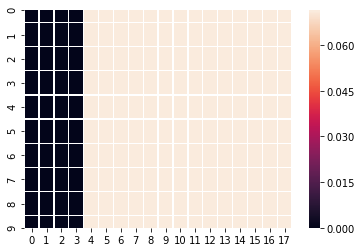

In [33]:
import seaborn as sns
sns.heatmap((attention_weights[index]), linewidths = 0.25)

In [34]:
convert_int2word(test_decoder_output)[:10]

['get away',
 'tom drives a truck',
 'can i pay later',
 'money cant buy life',
 'tom wont be missed',
 'tom is a very shy boy',
 'i have to feed my cat',
 'tom is very busy now',
 'they were shocked',
 'they said its ok']

In [26]:
from nltk.translate.bleu_score import corpus_bleu

actual = convert_int2word(y_test)
# actual = [line.split() for line in actual]
predicted = convert_int2word(np.argmax(preds, axis = 2))
# predicted = [line.split() for line in predicted]

# calculate BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.524960
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
